In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.var import VAR
from sklearn.metrics import mean_squared_error, r2_score


from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
import pmdarima as pmd

In [79]:
df = pd.read_csv('../data/fresno_eda.csv', index_col='datetime', parse_dates=True)
df = pd.DataFrame(df['precip'])

In [80]:
df.shape

(10959, 1)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1992-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  10959 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


In [82]:
df_week = df.resample('W').mean()
df_month = df.resample('M').mean()

In [83]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1566 entries, 1992-01-05 to 2022-01-02
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  1566 non-null   float64
dtypes: float64(1)
memory usage: 24.5 KB


In [84]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1992-01-31 to 2022-01-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [85]:
df_week.isnull().sum(), df_month.isnull().sum()

(precip    0
 dtype: int64,
 precip    0
 dtype: int64)

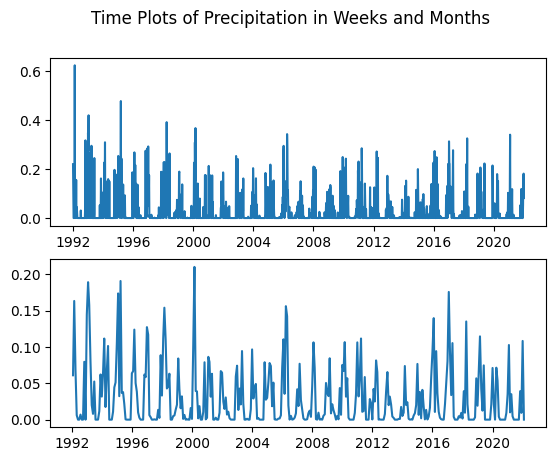

In [86]:
fig, ax = plt.subplots(2)
fig.suptitle('Time Plots of Precipitation in Weeks and Months')
ax[0].plot(df_week)
ax[1].plot(df_month)

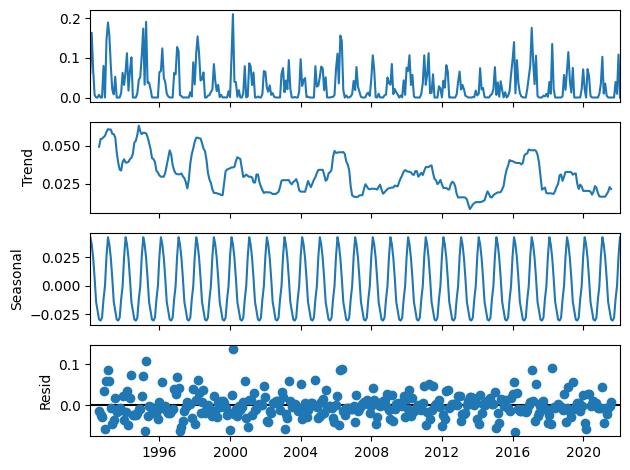

In [87]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_month)

# Plot the decomposed time series.
decomp.plot();

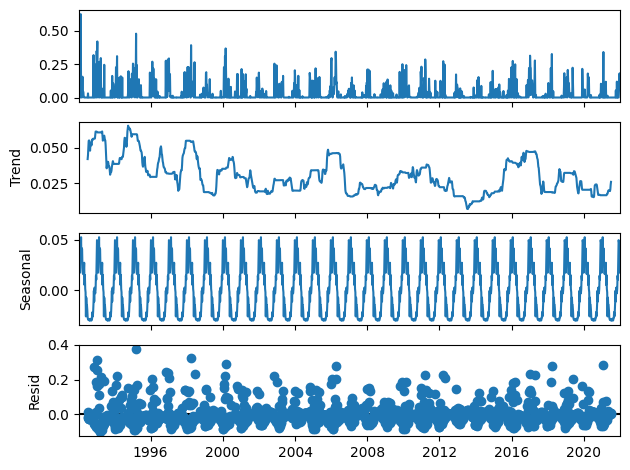

In [88]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_week)

# Plot the decomposed time series.
decomp.plot();

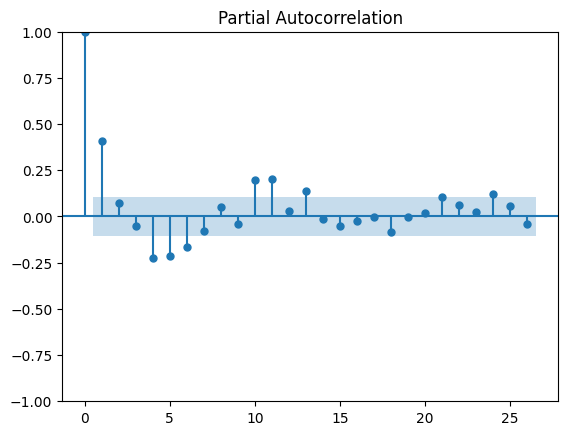

In [37]:
plot_pacf(df_month);

In [ ]:
# No trends because a majority of our lags are close to or under 0. 

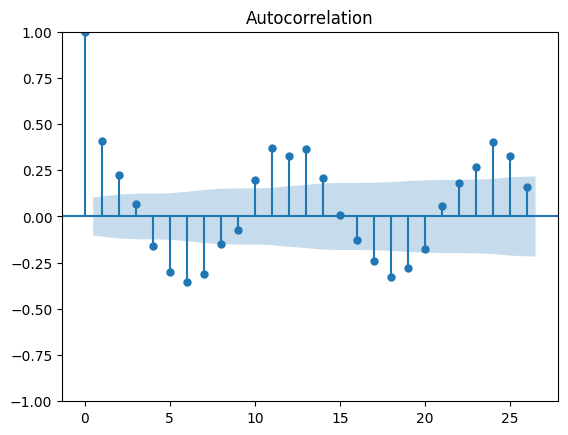

In [14]:
plot_acf(df_month);

In [142]:
train = df_month.loc[:'2021-09-01']

In [141]:
test = df_month.loc['2021-09-02':]

In [143]:
train.shape, test.shape

((356, 1), (5, 1))

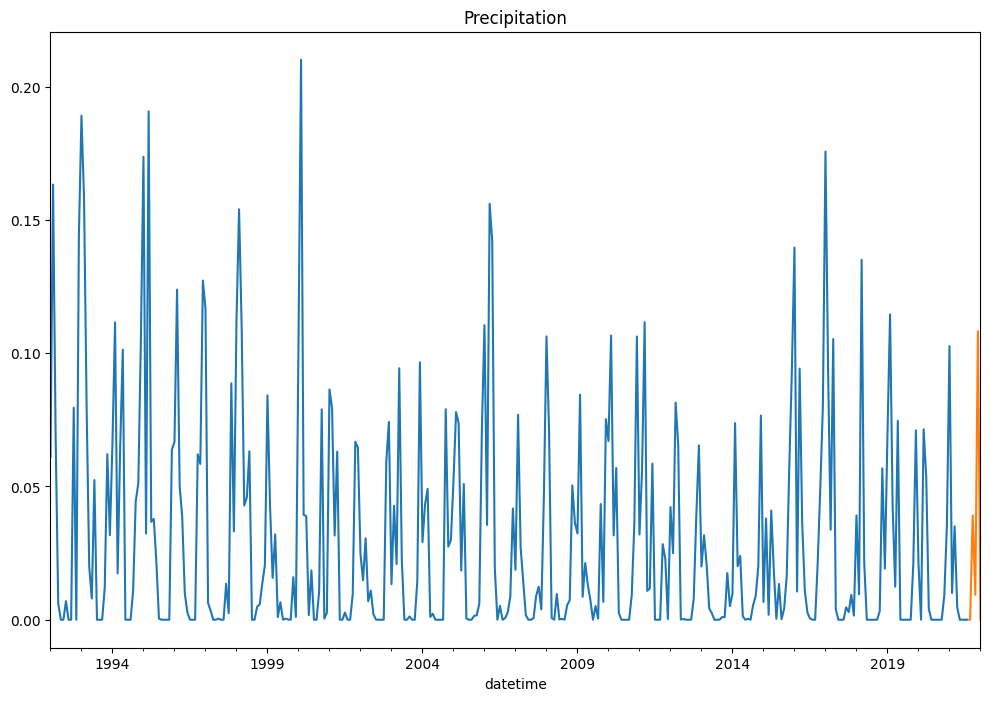

In [144]:
train['precip'].plot()
test['precip'].plot(figsize = (12, 8), title = 'Precipitation');

In [145]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [94]:
interpret_dftest(adfuller(df_month))

Test Statistic    -3.848855
p-value            0.002445
Lag Used          12.000000
dtype: float64

In [95]:
interpret_dftest(adfuller(df_week))

Test Statistic   -1.048062e+01
p-value           1.216424e-18
Lag Used          2.300000e+01
dtype: float64

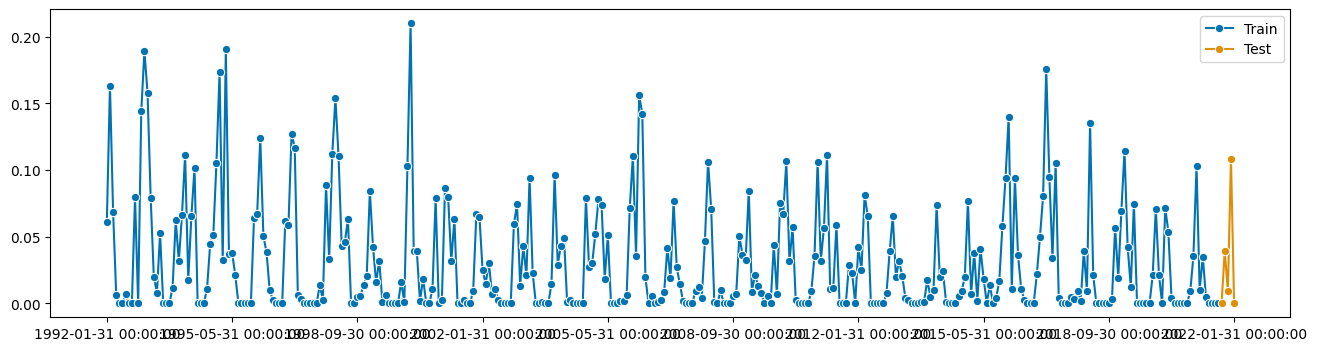

In [146]:
plot_series(train, test, labels = ['Train', 'Test']);

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

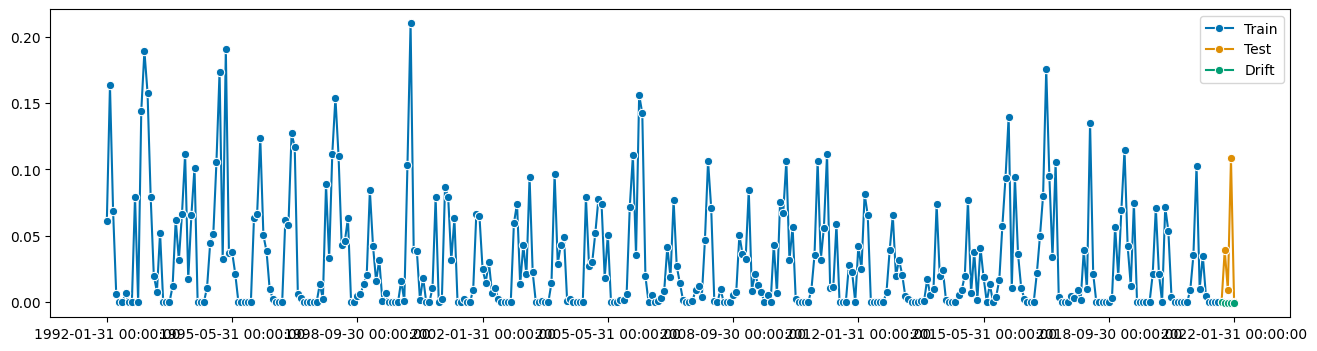

In [171]:

baseline_drift = NaiveForecaster(strategy = 'drift')

baseline_drift.fit(train)

baseline_drift_preds = baseline_drift.predict(test.index)

plot_series(train, test, baseline_drift_preds, labels = ['Train', 'Test', 'Drift'])

In [24]:
from sktime.forecasting.compose import EnsembleForecaster


In [173]:
model = pmd.auto_arima(
    train, 
    start_p=1, 
    start_q=1,
    max_p=2,                 # Hyndman says p almost never > 2
    max_q=2,
    d=0,                     # from ndiffs testing
    start_P=1, 
    start_Q=1,
    max_P=2,                
    max_Q=2,
    seasonal=True, 
    m=12,
    error_action='ignore',   # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
)

In [174]:
test.shape[0]

5

In [175]:
df_preds = model.predict(test.shape[0])

In [176]:
df_preds

2021-09-30    0.005152
2021-10-31    0.013211
2021-11-30    0.028732
2021-12-31    0.050238
2022-01-31    0.052402
Freq: M, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

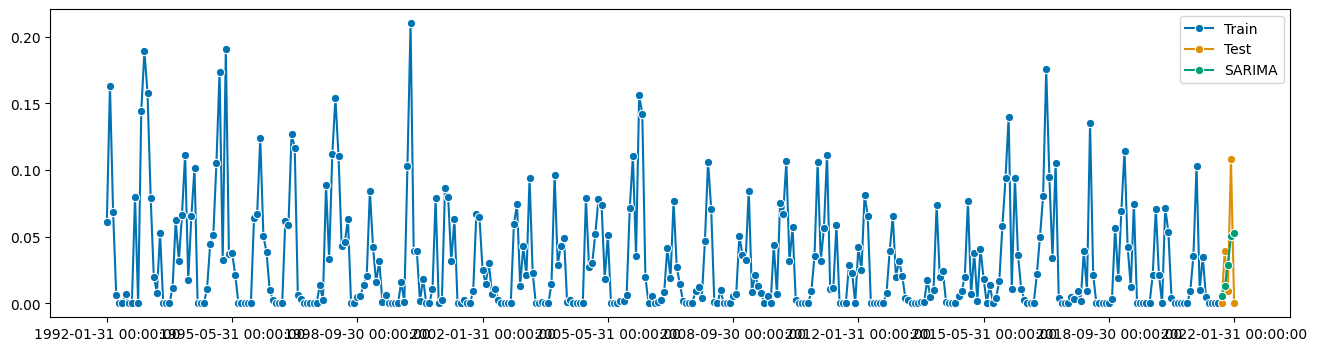

In [177]:
plot_series(train, test, df_preds,
           labels = ['Train', 'Test', 'SARIMA'])

In [178]:
r2_score(test, df_preds)

0.14702715627538

In [138]:
hw_model = AutoETS(sp = 12, seasonal='add', random_state=42)

hw_model.fit(train)

AutoETS(random_state=42, seasonal='add', sp=12)

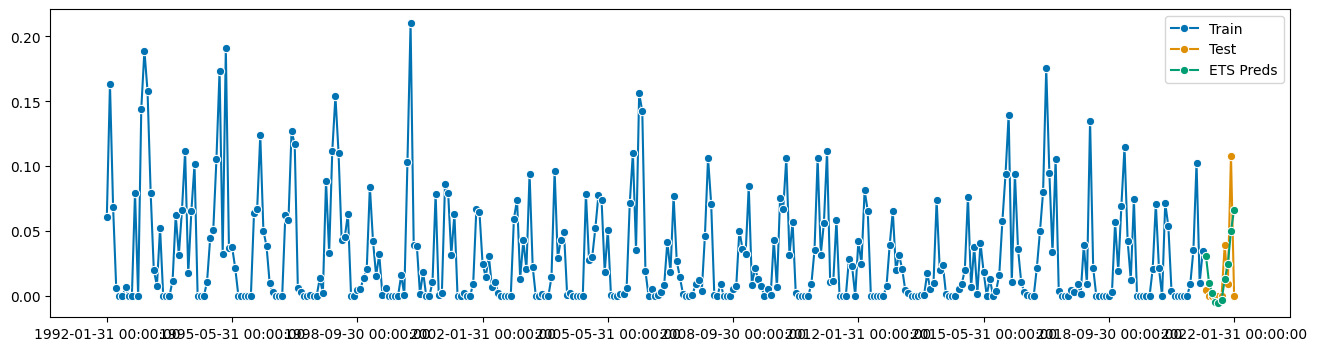

In [139]:

hw_preds = hw_model.predict(test.index)

plot_series(train, test, hw_preds, labels = ['Train', 'Test', 'ETS Preds']);

In [140]:
r2_score(test, hw_preds)

0.11259041870591258